# Generating Weekday and Weekend profiles

In [2]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 
import re
import os

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

from kmodes.kprototypes import KPrototypes

import pandas as pd

In [3]:
pattern = f"{"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_seasonal_normalized/SM_DATA_seasonal_normalized_summer"}/*CH*.csv"
file_paths = glob.glob(pattern)

In [4]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:15])  # Preview first 10 extracted CH... names

train_data = data_3d

n_samples = data_3d.shape[0]

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197', 'CH1018601234500000000000000019524', 'CH1018601234500000000000000080658', 'CH1018601234500000000000000018881', 'CH1018601234500000000000000108521', 'CH1018601234500000000000000113022']


In [5]:
#read the file according to the filenames extracted before

result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_summer_category.csv')

order_dict = {house_id: i for i, house_id in enumerate(filename_list)}

# List to hold DataFrames filtered by each filename
ordered_rows = [result_df.filter(pl.col("house_id") == filename) for filename in filename_list]

# Vertically concatenate all filtered rows preserving the order
ordered_result_df = pl.concat(ordered_rows)

print(ordered_result_df['house_id'].to_list()[:10])

['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [29]:
# Load categorical column as pandas category
category_df = ordered_result_df.select(['electric water heating', 'heat pump', 'solar panels'])

#category_df = ordered_result_df.select(['solar panels'])

category_array = category_df.to_numpy()

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_array])

print(ordered_result_df['house_id'].to_list()[:15])  # Preview first 10 house IDs

['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197', 'CH1018601234500000000000000019524', 'CH1018601234500000000000000080658', 'CH1018601234500000000000000018881', 'CH1018601234500000000000000108521', 'CH1018601234500000000000000113022']


Clusters: 2, Cost: 9794.650869968602
Clusters: 3, Cost: 8207.707573533795
Clusters: 4, Cost: 7301.2070619318765
Clusters: 5, Cost: 6298.279195441405
Clusters: 6, Cost: 6165.361047836696
Clusters: 7, Cost: 6097.254896944144
Clusters: 8, Cost: 5771.520262239762
Clusters: 9, Cost: 5124.2868230807635
Clusters: 10, Cost: 4925.180078159907
Clusters: 11, Cost: 4829.859936310128
Clusters: 12, Cost: 4806.443562548064
Clusters: 13, Cost: 4594.277431949326
Clusters: 14, Cost: 4640.918371554421
Clusters: 15, Cost: 4568.813918347387
Clusters: 16, Cost: 4469.169495485492


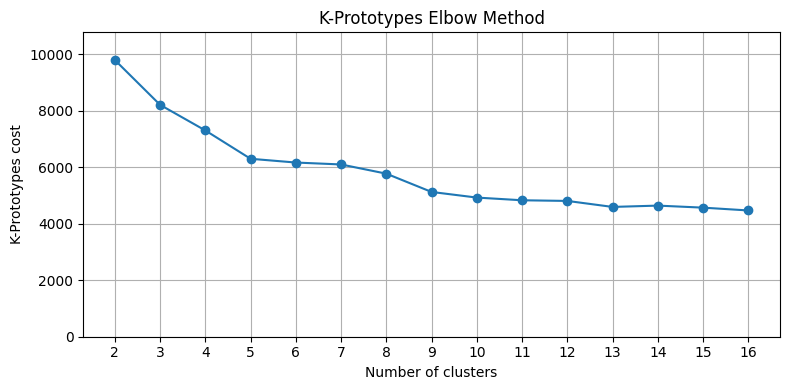

In [30]:
# 5. Specify the categorical feature column indices (the last 3 columns)
categorical_indices = list(range(combined_data.shape[1] - 3, combined_data.shape[1]))

cluster_range = range(2, 17)  # Try 2-10 clusters

costs = []

for n_clusters in cluster_range:
    kproto = KPrototypes(
        n_clusters=n_clusters,
        init='Cao',
        verbose=0,
        max_iter=200,
        gamma=5,
        random_state=42,
        n_init=10
    )
    kproto.fit_predict(combined_data, categorical=categorical_indices)
    costs.append(kproto.cost_)
    print(f"Clusters: {n_clusters}, Cost: {kproto.cost_}")

# Plotting the cost vs number of clusters
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('K-Prototypes cost')
plt.ylim(0, max(costs) * 1.1)
plt.title('K-Prototypes Elbow Method')
plt.xticks(cluster_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:



# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(
    n_clusters=4, 
    init='Cao', 
    verbose=0, 
    max_iter=200, 
    gamma=5,
    random_state=42,
    n_init=10
)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

clusters = clusters + 1

print("Cluster labels:")
print(clusters)

Cluster 1 size: 752
Cluster 2 size: 206
Cluster 3 size: 286
Cluster 4 size: 220


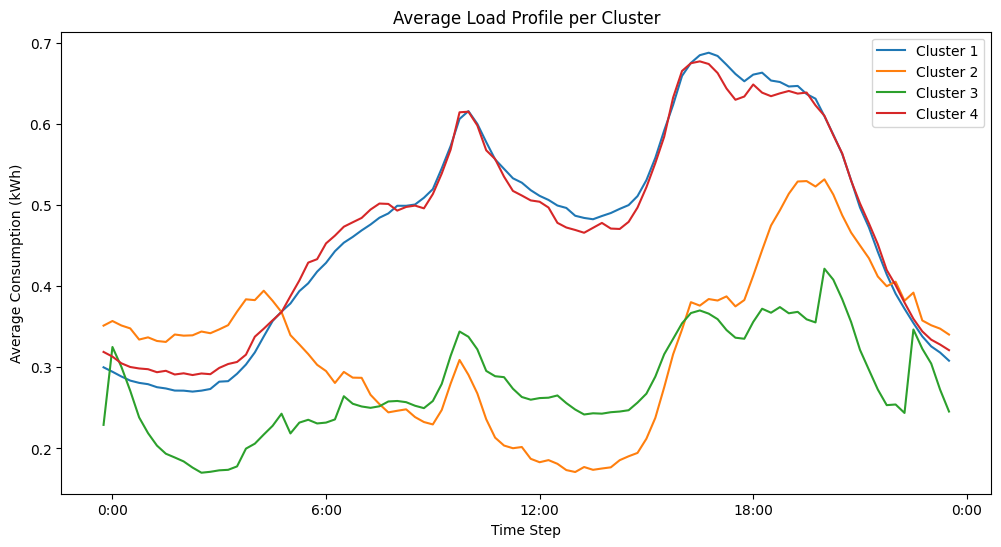

In [218]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']

plt.figure(figsize=(12, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')
    print(f'Cluster {cl} size: {len(idx)}')

plt.title('Average Load Profile per Cluster')
plt.xticks(range(1,120,24),labels=labels)
plt.xlabel('Time Step')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.show()



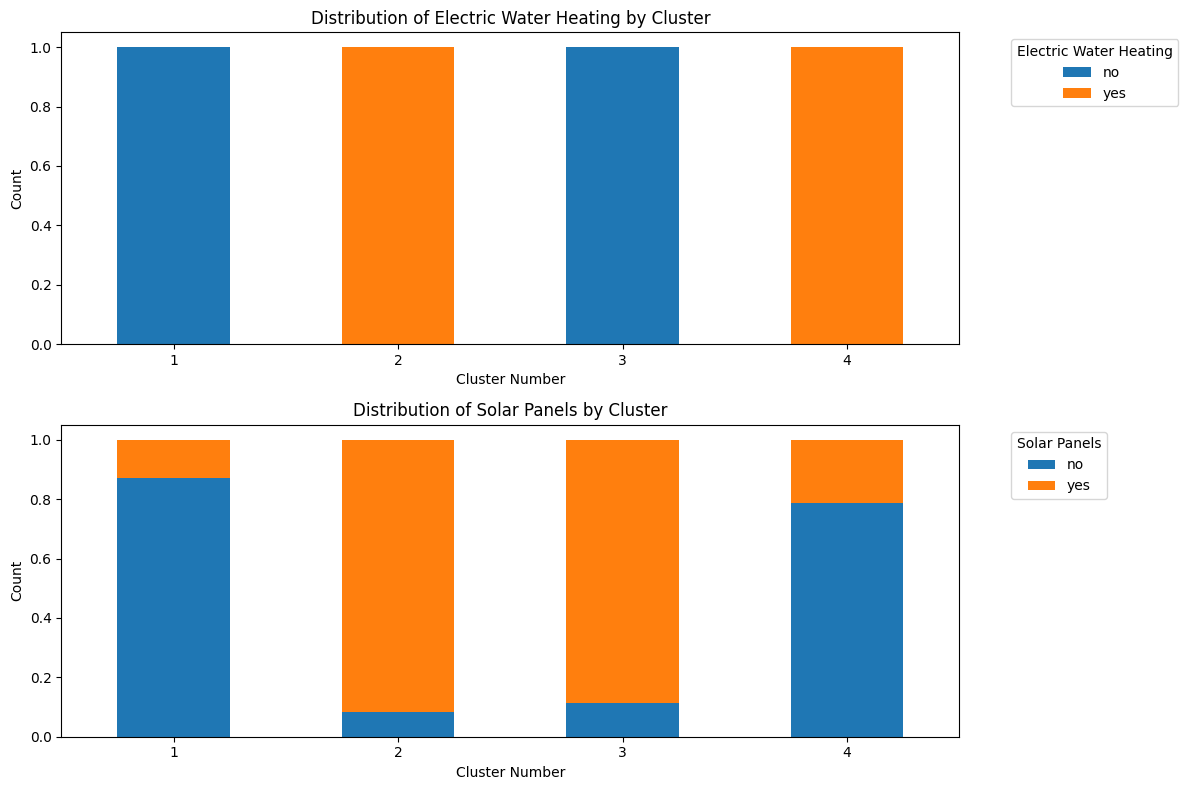

In [220]:
#decoded_categories = combined_data[:, -1].tolist()

# Create DataFrame with cluster labels and decoded categorical feature
df = pd.DataFrame({
    'cluster': clusters,
    'Electric Water Heating': combined_data[:, -1].tolist(),
    'Solar Panels': combined_data[:, -2].tolist()
})

# Number of categorical features to plot
category_features = ['Electric Water Heating', 'Solar Panels']
n_features = len(category_features)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    
    # Group and pivot data for plotting
    counts = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    
    # Rotate x-ticks for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [87]:
cluster_nums = [int(col.split()[1]) for col in final_table.columns]

# Calculate counts of samples per cluster from your cleaned df (df_cleaned)
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()

# Extract counts matching the cluster numbers (fill with 0 if cluster missing)
counts_for_clusters = [cluster_counts.get(c, 0) for c in cluster_nums]

# Create DataFrame row with counts, row index MultiIndex
new_row = pd.DataFrame(
    [counts_for_clusters],
    columns=final_table.columns,
    index=pd.MultiIndex.from_tuples([('Number of Households', '')], names=final_table.index.names)
)

# Append new row at bottom
final_table_with_counts = pd.concat([final_table, new_row])

# Display with formatting
display(final_table_with_counts.style.format("{:.2%}"))

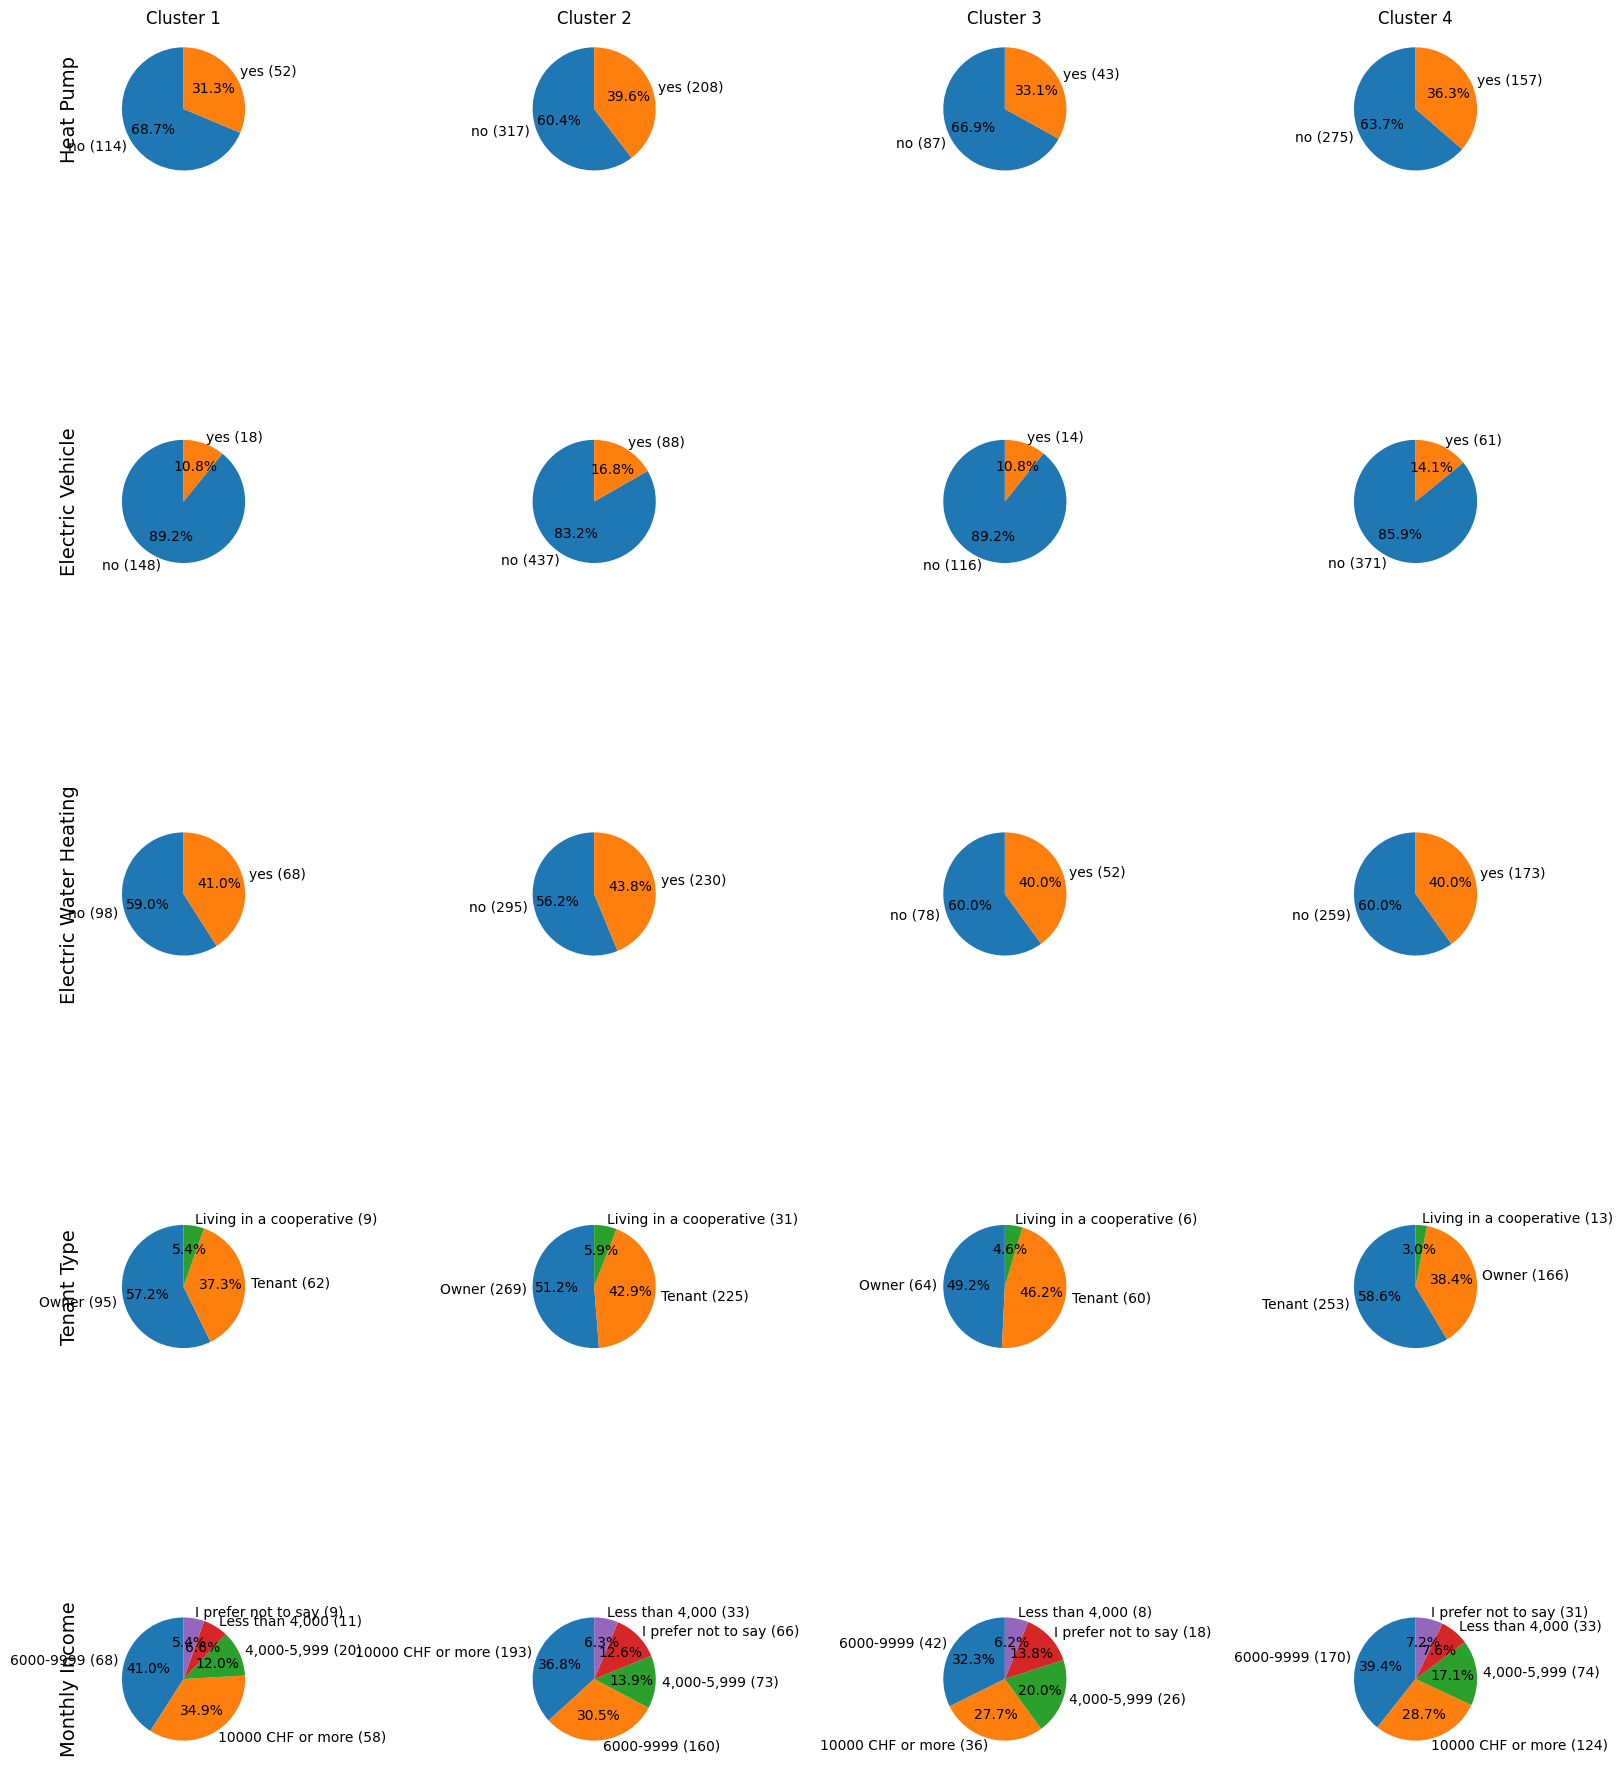

In [88]:
features = ['HP_decoded', 'EV_decoded', 'Electric Water Heating_decoded', 'Tenant Type_decoded', 'Monthly Income_decoded']

feature_label = ['Heat Pump', 'Electric Vehicle', 'Electric Water Heating', 'Tenant Type', 'Monthly Income']

# Get list of unique clusters sorted
clusters_sorted = sorted(df_cleaned['cluster'].unique())

n_features = len(features)
n_clusters = len(clusters_sorted)

fig, axes = plt.subplots(n_features, n_clusters, figsize=(4*n_clusters, 4*n_features))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters_sorted):

        ax = axes[i, j] if n_features > 1 else axes[j]

        data = df_cleaned[(df_cleaned['cluster'] == cluster) & (df_cleaned[feature].notna())][feature]

        counts = data.value_counts()
        
        # Create labels including category name and count
        labels = [f"{cat} ({count})" for cat, count in zip(counts.index, counts.values)]
        
        ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
        
        if i == 0:
            ax.set_title(f'Cluster {cluster}')
        if j == 0:
            ax.set_ylabel(feature_label[i], fontsize=14, labelpad=20)

plt.tight_layout()
plt.show()